# Análise Exploratória - Empresas Inidôneas e Suspensas

<div style="text-align:justify">
Este notebook realiza uma análise exploratória sobre os dados de Cadastro de Empresas Inidôneas e Suspensas (CEIS), disponíveis no Portal da Transparência e Controladoria Geral da União (CGU), acessíveis através do [Link](http://www.portaltransparencia.gov.br/downloads/snapshot.asp?c=CEIS#get).
</div>

<div style="text-align:justify">
Este notebook está sendo convertido de Pandas para Apache Spark
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe//
</div>

## Carregando Pacotes

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as func


import unicodedata
import re

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Carregando Dados

<div style="text-align:justify">
Os dados carregados apresentam: <br><br>
Tipo de Pessoa; CPF ou CNPJ do Sancionado; Nome Informado pelo Órgão Sancionador; Razão Social - Cadastro Receita; Nome Fantasia - Cadastro Receita; Número do processo; Tipo Sanção; Data Início Sanção; Data Final Sanção; Órgão Sancionador; UF Órgão Sancionador; Origem Informações; Data Origem Informações; Data Publicação; Publicação; Detalhamento; Abrangência definida em decisão judicial; Fundamentação Legal; Descrição da Fundamentação Legal; Data do Trânsito em Julgado; Complemento do Órgão; e Contato da Origem da Informação.
</div>

In [3]:
spark = SparkSession.builder.appName("dataset").getOrCreate()

dataframeSpark = spark.read.csv("../datasets/sancoes/20180331_CEIS.csv", header=True, sep=";", encoding='latin1').cache()
dataframeSpark.printSchema()

summary = dataframeSpark.describe() \
    .filter(func.col("summary") == "count") \
    .select(*(func.col(c).alias(c) for c in dataframeSpark.columns)) \
    .show()


root
 |-- Tipo de Pessoa: string (nullable = true)
 |-- CPF ou CNPJ do Sancionado: string (nullable = true)
 |-- Nome Informado pelo Órgão Sancionador: string (nullable = true)
 |-- Razão Social - Cadastro Receita: string (nullable = true)
 |-- Nome Fantasia - Cadastro Receita: string (nullable = true)
 |-- Número do processo: string (nullable = true)
 |-- Tipo Sanção: string (nullable = true)
 |-- Data Início Sanção: string (nullable = true)
 |-- Data Final Sanção: string (nullable = true)
 |-- Órgão Sancionador: string (nullable = true)
 |-- UF Órgão Sancionador: string (nullable = true)
 |-- Origem Informações: string (nullable = true)
 |-- Data Origem Informações: string (nullable = true)
 |-- Data Publicação: string (nullable = true)
 |-- Publicação: string (nullable = true)
 |-- Detalhamento: string (nullable = true)
 |-- Abrangência definida em decisão judicial: string (nullable = true)
 |-- Fundamentação Legal: string (nullable = true)
 |-- Descrição da Fundamentação Legal: str

Nota: Avaliar como transpor os dados para melhorar a visualização

In [4]:
dataset = pd.read_csv("../datasets/sancoes/20180331_CEIS.csv", sep=';', encoding='latin1')
dataset.count()

Tipo de Pessoa                              12537
CPF ou CNPJ do Sancionado                   12537
Nome Informado pelo Órgão Sancionador       12537
Razão Social - Cadastro Receita             12531
Nome Fantasia - Cadastro Receita             4528
Número do processo                          12537
Tipo Sanção                                 12537
Data Início Sanção                          12537
Data Final Sanção                           11384
Órgão Sancionador                           12536
UF Órgão Sancionador                        11547
Origem Informações                          12537
Data Origem Informações                     12537
Data Publicação                              6166
Publicação                                   5076
Detalhamento                                 2181
Abrangência definida em decisão judicial     1243
Fundamentação Legal                         12147
Descrição da Fundamentação Legal            12147
Data do Trânsito em Julgado                  5384


## Hipóteses de Análise:

- H1: Existe alguma predominância pelo tipo de pessoa
- H2: Existe alguma predominância pelo tipo de sanção
- H3: Algum orgão sancionador é mais predominante
- H4: Existe alguma predominância por UF do órgão sancionador
- H5: Existe alguma predominância por origem da informação

### H1: Predominância por Tipo de Pessoa

<div style="text-align:justify">
Podemos notar que não há predominância no número de sanções de acordo com o tipo de pessoa, muito embora a maior parte das sanções estejam associadas a Pessoas Jurídicas.
</div>

In [5]:
countByTipoPessoa = dataframeSpark \
    .groupBy(u"Tipo de Pessoa") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByTipoPessoa.show()

dataset[u"Tipo de Pessoa"].value_counts()

+--------------+-----+
|Tipo de Pessoa|total|
+--------------+-----+
|      Juridica| 6772|
|        Fisica| 5765|
+--------------+-----+



Juridica    6772
Fisica      5765
Name: Tipo de Pessoa, dtype: int64

### H2: Predominância pelo Tipo de Sanção

#### Tipo de Sanção Pessoa Física

<div style="text-align:justify">
Vamos agora fazer uma análise mais detalhada, avaliando a predominância de tipo de sanções por pessoa física. Podemos notar que é predominante o número de sanções do tipo _Proibição - Lei de Improbidade_, com 5420 ocorrências. Os demais tipo de sanções ocorrerm em número bem baixo, se comparado com este citado anteriormente.
</div>

In [6]:
countByTipoSancaoPessoaFisica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByTipoSancaoPessoaFisica.show(10)


dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"Tipo Sanção"].value_counts().head(10)

+--------------------+-----+
|         Tipo Sanção|total|
+--------------------+-----+
|Proibição - Lei d...| 5420|
|Decisão judicial ...|  136|
|Suspensão - Lei d...|   98|
|Impedimento - Lei...|   35|
|Inidoneidade - Le...|   22|
|Suspensão - Legis...|   19|
|Inidoneidade - Le...|   15|
|Proibição - Lei A...|    7|
|Impedimento - Leg...|    5|
|Inidoneidade - Le...|    4|
+--------------------+-----+
only showing top 10 rows



Proibição - Lei de Improbidade                              5420
Decisão judicial liminar/cautelar que impeça contratação     136
Suspensão - Lei de Licitações                                 98
Impedimento - Lei do Pregão                                   35
Inidoneidade - Lei de Licitações                              22
Suspensão - Legislação Estadual                               19
Inidoneidade - Legislação Estadual                            15
Proibição - Lei Antitruste                                     7
Impedimento - Legislação Estadual                              5
Inidoneidade - Lei Orgânica TCU                                4
Name: Tipo Sanção, dtype: int64

<div style="text-align:justify">
Analisando os cinco primeiros registros, notamos que quase 95% das sanções relacionadas a pessoa física são de _Proibição - Lei de Improbidade_, ou seja; enriquecimento ilicito.
</div>

In [26]:
qtdPessoaFisica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .count()
    
percByTipoSancaoPessoaFisica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaFisica)) \
    .drop("total")

percByTipoSancaoPessoaFisica.show(5)


tp_pf = dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"Tipo Sanção"].value_counts(normalize=True).head(5)
tp_pf

+--------------------+--------------------+
|         Tipo Sanção|                perc|
+--------------------+--------------------+
|Proibição - Lei d...|  0.9401561144839549|
|Decisão judicial ...|0.023590633130962706|
|Suspensão - Lei d...| 0.01699913269731136|
|Impedimento - Lei...|0.006071118820468344|
|Inidoneidade - Le...|0.003816131830008673|
+--------------------+--------------------+
only showing top 5 rows



Proibição - Lei de Improbidade                              0.940156
Decisão judicial liminar/cautelar que impeça contratação    0.023591
Suspensão - Lei de Licitações                               0.016999
Impedimento - Lei do Pregão                                 0.006071
Inidoneidade - Lei de Licitações                            0.003816
Name: Tipo Sanção, dtype: float64

#### Representação Gráfica - Pessoa Física

/home/gustavo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


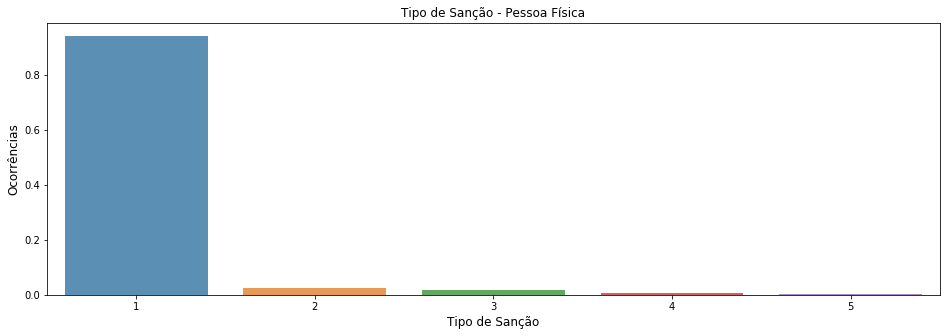

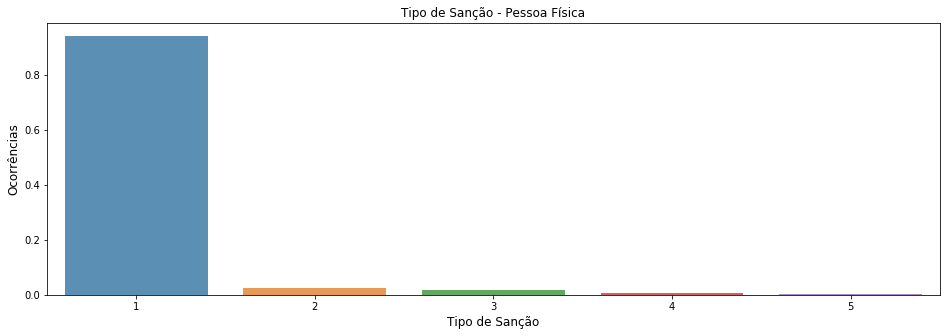

In [8]:
plt.figure(figsize=(16, 5))
percTipoSancao = np.array(percByTipoSancaoPessoaFisica.select("perc").collect()).ravel()
percTipoSancao = percTipoSancao[:5]
sns.barplot(list(range(1, percTipoSancao.size + 1)), percTipoSancao, alpha=0.8)
plt.title(u"Tipo de Sanção - Pessoa Física")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Tipo de Sanção", fontsize=12)
plt.show()

plt.figure(figsize=(16, 5))
sns.barplot(list(range(1, tp_pf.count() + 1)), tp_pf.values, alpha=0.8)
plt.title(u"Tipo de Sanção - Pessoa Física")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Tipo de Sanção", fontsize=12)
plt.show()

#### Tipo de Sanção Pessoa Jurídica

<div style="text-align:justify">
Vamos agora analisar a predominância de tipo de sanções por pessoa jurídica. Podemos notar que o maior número de ocorrências é o _Impedimento - Lei do Pregão_, com 2125 sanções; seguido de 1953 _Suspensão - Lei de Licitações_.
</div>

In [9]:
countByTipoSancaoPessoaJuridica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByTipoSancaoPessoaJuridica.show(10)

dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"Tipo Sanção"].value_counts().head(10)

+--------------------+-----+
|         Tipo Sanção|total|
+--------------------+-----+
|Impedimento - Lei...| 2125|
|Suspensão - Lei d...| 1953|
|Inidoneidade - Le...|  663|
|Proibição - Lei d...|  562|
|Inidoneidade - Le...|  393|
|Proibição - Lei E...|  240|
|Inidoneidade - Le...|  196|
|Inidoneidade - Le...|  189|
|Suspensão - Legis...|  176|
|Decisão judicial ...|  106|
+--------------------+-----+
only showing top 10 rows



Impedimento - Lei do Pregão                                 2125
Suspensão - Lei de Licitações                               1953
Inidoneidade - Lei de Licitações                             663
Proibição - Lei de Improbidade                               562
Inidoneidade - Legislação Estadual                           393
Proibição - Lei Eleitoral                                    240
Inidoneidade - Lei da ANTT e ANTAQ                           196
Inidoneidade - Lei Orgânica TCU                              189
Suspensão - Legislação Estadual                              176
Decisão judicial liminar/cautelar que impeça contratação     106
Name: Tipo Sanção, dtype: int64

<div style="text-align:justify">
Analisando os cinco primeiros registros, notamos que os dois primeiros tipos de sanções de pessoa jurídica representam aproximadamente 30% cada, das sanções para esse grupo de pessoa.
</div>

In [28]:
qtdPessoaJuridica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .count()
    
percByTipoSancaoPessoaJuridica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaJuridica)) \
    .drop("total")

percByTipoSancaoPessoaJuridica.show(5)

tp_pj = dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"Tipo Sanção"].value_counts(normalize=True).head(5)
tp_pj

+--------------------+-------------------+
|         Tipo Sanção|               perc|
+--------------------+-------------------+
|Impedimento - Lei...| 0.3137920850561134|
|Suspensão - Lei d...| 0.2883933845245127|
|Inidoneidade - Le...|0.09790313053750738|
|Proibição - Lei d...|0.08298877731836976|
|Inidoneidade - Le...| 0.0580330773774365|
+--------------------+-------------------+
only showing top 5 rows



Impedimento - Lei do Pregão           0.313792
Suspensão - Lei de Licitações         0.288393
Inidoneidade - Lei de Licitações      0.097903
Proibição - Lei de Improbidade        0.082989
Inidoneidade - Legislação Estadual    0.058033
Name: Tipo Sanção, dtype: float64

#### Representação Gráfica - Pessoa Jurídica

/home/gustavo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


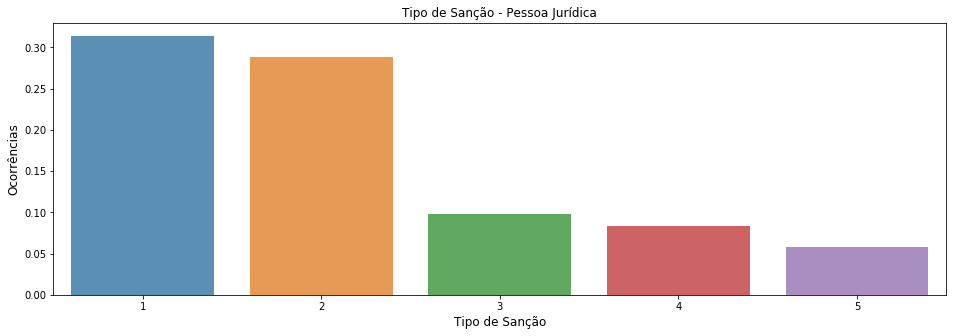

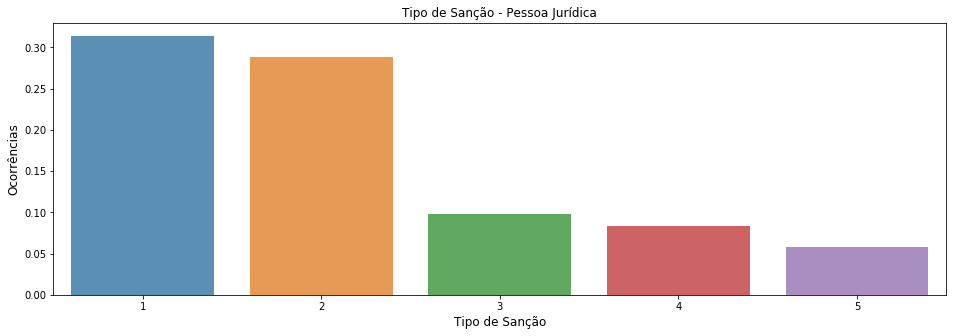

In [29]:
plt.figure(figsize=(16, 5))
percTipoSancao = np.array(percByTipoSancaoPessoaJuridica.select("perc").collect()).ravel()
percTipoSancao = percTipoSancao[:5]
sns.barplot(list(range(1, percTipoSancao.size + 1)), percTipoSancao, alpha=0.8)
plt.title(u"Tipo de Sanção - Pessoa Jurídica")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Tipo de Sanção", fontsize=12)
plt.show()

plt.figure(figsize=(16, 5))
sns.barplot(list(range(1, tp_pj.count() + 1)), tp_pj.values, alpha=0.8)
plt.title(u"Tipo de Sanção - Pessoa Jurídica")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Tipo de Sanção", fontsize=12)
plt.show()

### H3: Predominância por Órgão Sancionador

<div style="text-align:justify">
A maior parte das sanções são executadas pela Justiça Estadual, com 556 ocorrências; seguida da Justiça Federal com  366 e Procuradoria Geral do Estado, com 336 sanções.
</div>

In [30]:
countByOrgaoSancionador = dataframeSpark \
    .groupBy(u"Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByOrgaoSancionador.show(10)

dataset[u"Órgão Sancionador"].value_counts().head(10)

+--------------------+-----+
|   Órgão Sancionador|total|
+--------------------+-----+
|    Justiça Estadual|  556|
|     Justiça Federal|  366|
|PROCURADORIA GERA...|  336|
|Governo do Estado...|  305|
|AGÊNCIA NACIONAL ...|  212|
|EMPRESA BRASILEIR...|  194|
|CAIXA ECONÔMICA F...|  181|
|Governo do Estado...|  161|
|Receita Federal d...|  131|
|TRIBUNAL DE CONTA...|  125|
+--------------------+-----+
only showing top 10 rows



Justiça Estadual                               556
Justiça Federal                                366
PROCURADORIA GERAL DO ESTADO                   336
Governo do Estado da Bahia                     305
AGÊNCIA NACIONAL DE TRANSPORTES TERRESTRES     212
EMPRESA BRASILEIRA DE CORREIOS E TELÉGRAFOS    194
CAIXA ECONÔMICA FEDERAL                        181
Governo do Estado da Bahia (BA)                161
Receita Federal do Brasil                      131
TRIBUNAL DE CONTAS DA UNIÃO                    125
Name: Órgão Sancionador, dtype: int64

<div style="text-align:justify">
Quando analisamos em valores percentuais, observamos que não existe predominância em nenhum órgão sancionador; ou seja, há um balanceamento entre as sanções de todos os órgãos.
</div>

In [31]:
qtdTotal = dataframeSpark.count()
    
percByOrgaoSancionador = dataframeSpark \
    .groupBy(u"Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdTotal)) \
    .drop("total")

percByOrgaoSancionador.show(5)

dataset[u"Órgão Sancionador"].value_counts(normalize=True).head(5)

+--------------------+--------------------+
|   Órgão Sancionador|                perc|
+--------------------+--------------------+
|    Justiça Estadual|0.044348727765813195|
|     Justiça Federal|0.029193586982531706|
|PROCURADORIA GERA...| 0.02680067001675042|
|Governo do Estado...|0.024327989152109757|
|AGÊNCIA NACIONAL ...|0.016909946558187765|
+--------------------+--------------------+
only showing top 5 rows



Justiça Estadual                              0.044352
Justiça Federal                               0.029196
PROCURADORIA GERAL DO ESTADO                  0.026803
Governo do Estado da Bahia                    0.024330
AGÊNCIA NACIONAL DE TRANSPORTES TERRESTRES    0.016911
Name: Órgão Sancionador, dtype: float64

### H4: Predominância por UF

#### UR Órgão Sancionador - Pessoa Física

<div style="text-align:justify">
Vamos verificar se existe predominância nas sanções por UF do Órgão Sancionador para cada tipo de pessoa. Começamos a análise com as sanções de pessoas físicas.
</div>

In [37]:
countByUFOrgaoSancionadorPessoaFisica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .groupBy(u"UF Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByUFOrgaoSancionadorPessoaFisica.show(10)

uf_pf = dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"UF Órgão Sancionador"].value_counts().head(10)
uf_pf

+--------------------+-----+
|UF Órgão Sancionador|total|
+--------------------+-----+
|                  SP| 1278|
|                  PR|  335|
|                  MG|  307|
|                  RS|  272|
|                  MA|  259|
|                  RN|  234|
|                  PE|  226|
|                  RJ|  225|
|                  PB|  186|
|                  GO|  172|
+--------------------+-----+
only showing top 10 rows



SP    1278
PR     335
MG     307
RS     272
MA     259
RN     234
PE     226
RJ     225
PB     186
GO     172
Name: UF Órgão Sancionador, dtype: int64

#### Representação Gráfica - Pessoa Física

/home/gustavo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


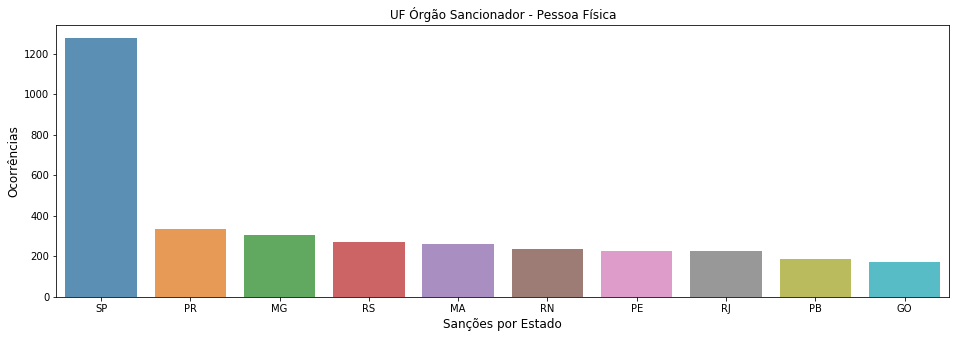

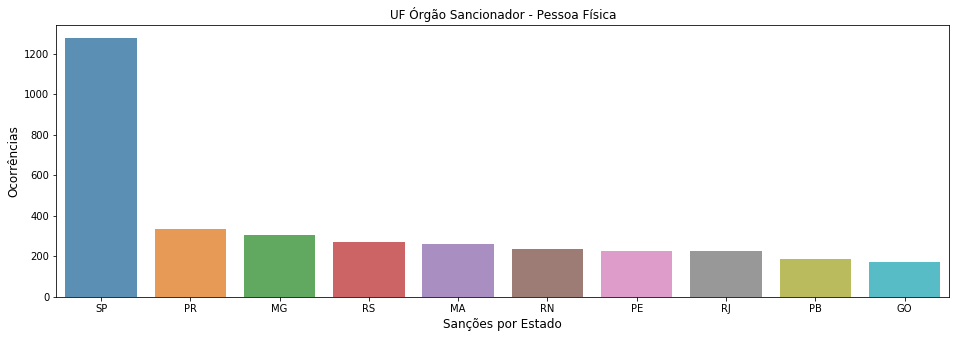

In [57]:
plt.figure(figsize=(16, 5))
qtdUFOrgaoSancionadorPessoaFisica = np.array(countByUFOrgaoSancionadorPessoaFisica.select("total").collect()).ravel()
qtdUFOrgaoSancionadorPessoaFisica = qtdUFOrgaoSancionadorPessoaFisica[:10]

ufPessoaFisica = np.array(countByUFOrgaoSancionadorPessoaFisica.select(u"UF Órgão Sancionador").collect()).ravel()
ufPessoaFisica = ufPessoaFisica[:10]


sns.barplot(ufPessoaFisica, qtdUFOrgaoSancionadorPessoaFisica, alpha=0.8)
plt.title(u"UF Órgão Sancionador - Pessoa Física")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Sanções por Estado", fontsize=12)
plt.show()

plt.figure(figsize=(16, 5))
sns.barplot(uf_pf.index, uf_pf.values, alpha=0.8)
plt.title(u"UF Órgão Sancionador - Pessoa Física")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Sanções por Estado", fontsize=12)
plt.show()

<div style="text-align:justify">
Ao exibir os valores percentuais, notamos que mais de 25% das sanções relacionadas as pessoas físicas se originam no estado de São Paulo. Os demais estados representam menos de 7% cada.
</div>

In [49]:
qtdPessoaFisicaComUFSancionador = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .count()
    
percByOrgaoSancionador = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .groupBy(u"UF Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaFisicaComUFSancionador)) \
    .drop("total")

percByOrgaoSancionador.show(5)


dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"UF Órgão Sancionador"].value_counts(normalize=True).head(5)

+--------------------+-------------------+
|UF Órgão Sancionador|               perc|
+--------------------+-------------------+
|                  SP|0.25849514563106796|
|                  PR|0.06775889967637541|
|                  MG|0.06209546925566343|
|                  RS|0.05501618122977346|
|                  MA|0.05238673139158576|
+--------------------+-------------------+
only showing top 5 rows



SP    0.258495
PR    0.067759
MG    0.062095
RS    0.055016
MA    0.052387
Name: UF Órgão Sancionador, dtype: float64

<div style="text-align:justify">
É interessante notar que quase 96% das sanções relacionadas a pessoas físicas dos estado de São Paulo são referentes a _Proibição - Lei de Improbidade_, ou seja, segue a mesmo percentual geral.
</div>

In [52]:
qtdPessoaFisicaComSancionadorSP = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .filter(func.col(u"UF Órgão Sancionador") == "SP") \
    .count()
    
percByTipoSancao = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Fisica") \
    .filter(func.col(u"UF Órgão Sancionador") == "SP") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaFisicaComSancionadorSP)) \
    .drop("total")

percByTipoSancao.show(5)
    
    
dataset.loc[ \
    (dataset[u"Tipo de Pessoa"] == "Fisica") & \
    (dataset[u"UF Órgão Sancionador"] == "SP") \
][u"Tipo Sanção"].value_counts(normalize=True).head(5)

+--------------------+--------------------+
|         Tipo Sanção|                perc|
+--------------------+--------------------+
|Proibição - Lei d...|  0.9585289514866979|
|Decisão judicial ...|0.017214397496087636|
|Suspensão - Lei d...|0.010172143974960876|
|Inidoneidade - Le...| 0.00782472613458529|
|Impedimento - Lei...|0.006259780907668232|
+--------------------+--------------------+



Proibição - Lei de Improbidade                              0.958529
Decisão judicial liminar/cautelar que impeça contratação    0.017214
Suspensão - Lei de Licitações                               0.010172
Inidoneidade - Lei de Licitações                            0.007825
Impedimento - Lei do Pregão                                 0.006260
Name: Tipo Sanção, dtype: float64

#### UR Órgão Sancionador - Pessoa Jurídica

<div style="text-align:justify">
Quanto as sanções por UF do Órgão Sancionador para pessoa jurídica, notamos que os estados de São Paulo e Distrito Federal se destacam, seguidos da Bahia e Rio de Janeiro.
</div>

In [53]:
countByUFOrgaoSancionadorPessoaJuridica = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .groupBy(u"UF Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache()

countByUFOrgaoSancionadorPessoaJuridica.show(10)

uf_pj = dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"UF Órgão Sancionador"].value_counts().head(10)
uf_pj

+--------------------+-----+
|UF Órgão Sancionador|total|
+--------------------+-----+
|                  DF| 1653|
|                  SP| 1049|
|                  BA|  602|
|                  RJ|  459|
|                  MG|  427|
|                  PR|  404|
|                  RS|  392|
|                  SC|  194|
|                  RN|  146|
|                  ES|  124|
+--------------------+-----+
only showing top 10 rows



DF    1653
SP    1049
BA     602
RJ     459
MG     427
PR     404
RS     392
SC     194
RN     146
ES     124
Name: UF Órgão Sancionador, dtype: int64

#### Representação Gráfica - Pessoa Jurídica

/home/gustavo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


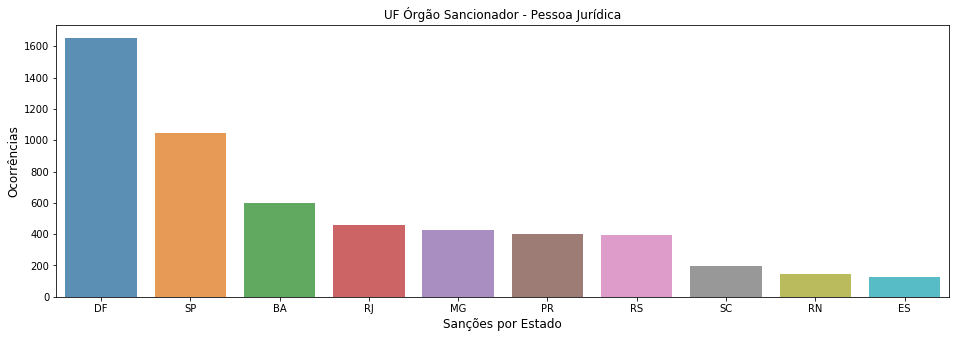

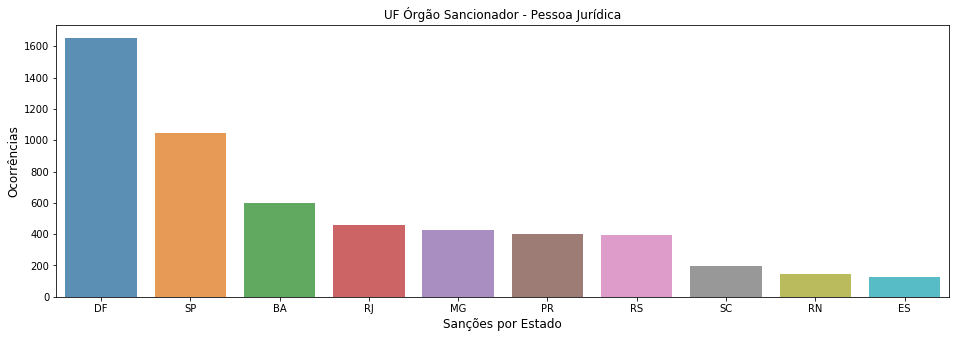

In [55]:
plt.figure(figsize=(16, 5))
qtdUFOrgaoSancionadorPessoaJuridica = np.array(countByUFOrgaoSancionadorPessoaJuridica.select("total").collect()).ravel()
qtdUFOrgaoSancionadorPessoaJuridica = qtdUFOrgaoSancionadorPessoaJuridica[:10]

ufPessoaJuridica = np.array(countByUFOrgaoSancionadorPessoaJuridica.select(u"UF Órgão Sancionador").collect()).ravel()
ufPessoaJuridica = ufPessoaJuridica[:10]

sns.barplot(ufPessoaJuridica, qtdUFOrgaoSancionadorPessoaJuridica, alpha=0.8)
plt.title(u"UF Órgão Sancionador - Pessoa Jurídica")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Sanções por Estado", fontsize=12)
plt.show()

plt.figure(figsize=(16, 5))
sns.barplot(uf_pj.index, uf_pj.values, alpha=0.8)
plt.title(u"UF Órgão Sancionador - Pessoa Jurídica")
plt.ylabel(u"Ocorrências", fontsize=12)
plt.xlabel(u"Sanções por Estado", fontsize=12)
plt.show()

<div style="text-align:justify">
Ao exibir os valores percentuais, notamos que mais de 25% das sanções relacionadas as pessoas jurídicas se originam no estado do Distrito Federal, seguido de São Paulo com 15% e Bahia com 9%.
</div>

In [58]:
qtdPessoaJuridicaComUFSancionador = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .count()
    
percByOrgaoSancionador = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .filter(func.col(u"UF Órgão Sancionador").isNotNull()) \
    .groupBy(u"UF Órgão Sancionador") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaJuridicaComUFSancionador)) \
    .drop("total")

percByOrgaoSancionador.show(5)

dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"UF Órgão Sancionador"].value_counts(normalize=True).head(5)

+--------------------+-------------------+
|UF Órgão Sancionador|               perc|
+--------------------+-------------------+
|                  DF| 0.2503407542026352|
|                  SP|0.15886718158412844|
|                  BA|0.09117067999394214|
|                  RJ|0.06951385733757383|
|                  MG|0.06466757534454036|
+--------------------+-------------------+
only showing top 5 rows



DF    0.250341
SP    0.158867
BA    0.091171
RJ    0.069514
MG    0.064668
Name: UF Órgão Sancionador, dtype: float64

<div style="text-align:justify">
É interessante notar que aproximadamente 30% das sanções relacionadas a pessoas jurídica do estado do Distrito Federal são referentes a _Suspensão - Lei de Licitações_ e _Impedimento - Lei do Pregão_, ou seja, segue a mesmo percentual geral.
</div>

In [59]:
qtdPessoaJuridicaComSancionadorDF = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .filter(func.col(u"UF Órgão Sancionador") == "DF") \
    .count()
    
percByTipoSancao = dataframeSpark \
    .filter(func.col(u"Tipo de Pessoa") == "Juridica") \
    .filter(func.col(u"UF Órgão Sancionador") == "DF") \
    .groupBy(u"Tipo Sanção") \
    .agg(func.count("*").alias("total")) \
    .orderBy(func.desc("total")) \
    .cache() \
    .withColumn('perc', func.col("total")/float(qtdPessoaJuridicaComSancionadorDF)) \
    .drop("total")

percByTipoSancao.show(5)

dataset.loc[ \
    (dataset[u"Tipo de Pessoa"] == "Juridica") & \
    (dataset[u"UF Órgão Sancionador"] == "DF") \
][u"Tipo Sanção"].value_counts(normalize=True).head(5)

+--------------------+-------------------+
|         Tipo Sanção|               perc|
+--------------------+-------------------+
|Suspensão - Lei d...|0.33998790078644886|
|Impedimento - Lei...| 0.2849364791288566|
|Inidoneidade - Le...|0.11796733212341198|
|Inidoneidade - Le...|0.11796733212341198|
|Inidoneidade - Le...| 0.0852994555353902|
+--------------------+-------------------+
only showing top 5 rows



Suspensão - Lei de Licitações         0.339988
Impedimento - Lei do Pregão           0.284936
Inidoneidade - Lei de Licitações      0.117967
Inidoneidade - Lei da ANTT e ANTAQ    0.117967
Inidoneidade - Lei Orgânica TCU       0.085299
Name: Tipo Sanção, dtype: float64

### H5: Predominância por Origem da Informação

#### Origem das Sanções de Pessoa Física

<div style="text-align:justify">
Mais de 81% das sanções relacionadas a pessoas físicas são originadas no Conselho Nacional de Justiça. Os demais órgãos possuem menos de 6% cada. As sanções de pessoas físicas são predominantes a uma origem.
</div>

In [22]:
dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"Origem Informações"].value_counts(normalize=True).head(5)

Conselho Nacional de Justiça              0.815785
Governo do Estado de São Paulo            0.055854
Governo do Estado do Rio Grande do Sul    0.013183
ADVOCACIA-GERAL DA UNIÃO                  0.009540
Justiça do Estado de São Paulo            0.007806
Name: Origem Informações, dtype: float64

#### Origem das Sanções de Pessoa Jurídica

<div style="text-align:justify">
Não existe predominância na origem das sanções abertas para pessoas jurídicas.
</div>

In [23]:
dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"Origem Informações"].value_counts(normalize=True).head(5)

Governo do Estado de São Paulo                 0.100856
Governo do Estado da Bahia (BA)                0.071028
Conselho Nacional de Justiça                   0.069699
AGÊNCIA NACIONAL DE TRANSPORTES TERRESTRES     0.031305
EMPRESA BRASILEIRA DE CORREIOS E TELÉGRAFOS    0.028647
Name: Origem Informações, dtype: float64

### Top 5 Pessoas Físicas e Jurídicas

<div style="text-align:justify">
A seguir, as Top 5 pessoas físicas com maior número de sanções registradas:
</div>

In [24]:
dataset.loc[dataset[u"Tipo de Pessoa"] == "Fisica"][u"Razão Social - Cadastro Receita"].value_counts().head(5)

LUIZ ANTONIO TREVISAN VEDOIN    34
DARCI JOSE VEDOIN               31
VALTERCIDES MONTEIRO            11
MARCOS PEREZ                    11
JOSE APARECIDO BRESSANE         10
Name: Razão Social - Cadastro Receita, dtype: int64

<div style="text-align:justify">
A seguir, as Top 5 pessoas jurídicas com maior número de sanções registradas:
</div>

In [25]:
dataset.loc[dataset[u"Tipo de Pessoa"] == "Juridica"][u"Razão Social - Cadastro Receita"].value_counts().head(5)

VAN COOPER COOPERATIVA DE TRABALHO DOS TRANSPORTADORES RODOVIARIOS DE CARGAS, PASSAGEIROS E SERVICOS.    28
SPEED  DISTRIBUIDORA E SERVICOS - EIRELI                                                                 23
PH SERVICOS E ADMINISTRACAO LTDA                                                                         21
COOPERSEMO COOPERATIVA DE SERVICOS DE TRANSPORTES                                                        18
SANDES CONSERVACAO SERVICOS EIRELI                                                                       14
Name: Razão Social - Cadastro Receita, dtype: int64

## Conclusões

- As sanções estão bem distribuídas entre os tipos de pessoas, não existe predominância.
- As sanções de Pessoa Física se destacam em proibição pela lei de improbidade.
- As sanções de Pessoas Jurídicas se concentram em irregularidaes em licitações e pregões.
- Não existe predominância por órgão sancionador.
- É predominante o número de sanções relacionadas a pessoas físicas no estado de São Paulo.
- As sanções relacionadas a pessoas jurídicas ocorrem com mais frequência no Distrito Federal e em São Paulo.
- Não existe prodominância da UF da sanção para pessoa jurídica, mas para pessoa física existe.